<a href="https://colab.research.google.com/github/Location-Artistry/ColabNotebooks/blob/master/paDataPyMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Working Notebook for visualizing in GeoPandas
Edited Sep 7th - GeoPandas can directly load GeoJSON from url, does not work with regular JSON   
Working to flatten/normalize nested json with Pandas/GeoPandas   
Additionally bring in ArcGIS Feature Service as DataFrame/GeoDataFrame
Sep 8th - Bring in PA Data from json as GeoDataFrame!
Can bring GDF directly into Folium

In [ ]:
%%time 
#!apt update
#!apt upgrade
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
!pip install pygeos
#!pip install flatten_json 

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import os
from IPython.display import display
from pandas.io.json import json_normalize
#from flatten_json import flatten 
import requests

/usr/local/lib/python3.6/dist-packages/geopandas/_compat.py:87: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


#Start Working Section

##9-8-2020
Working successfully to bring in miCounties GeoJSON as gdf and parse NHBPpa   
data from json - > dataFrame -> add geomtery from lat.long->create gdf


In [10]:
def GeoJSONtoGDF(jsonURL):
  geoDF = gpd.read_file(jsonURL)
  display(geoDF.head())
  return geoDF

In [11]:
NHBPpa = 'https://purpleairwidget.firebaseapp.com/purpleAirData/44439,2822,5712,43297,7772,37659'
PAallSta = 'https://www.purpleair.com/json'
miCounties = 'https://opendata.arcgis.com/datasets/67a8ff23b5f54f15b7133b8c30981441_0.geojson'

gdf = GeoJSONtoGDF(NHBPpa)
gdf2 = GeoJSONtoGDF(miCounties)
#gdf3 = GeoJSONtoGDF(PAallSta)
#dfPD = pd.read_json(NHBPpa)
#dfPD

,ID,label,flagged_high,version,WiFiSignal,PM2_5Value,sensorDiff,AQI,AQIText,AQI1Hour,AQI1HourText,AQI24Hour,AQI24HourText,AQI1Week,AQI1WeekText,geometry
0,44439,NHBP,0.0,6.01,-60,2.71,1.14,11,Good,10,Good,33,Good,41,Good,POINT (-85.26918 42.10240)
1,2822,Milton Township,NaN,6.01,-65,3.88,2.05,16,Good,16,Good,24,Good,28,Good,POINT (-86.17218 41.76787)
2,5712,Harlan,NaN,6.01,-49,4.31,1.31,18,Good,25,Good,66,Moderate,56,Moderate,POINT (-84.93002 41.19428)
3,43297,SFront,NaN,6.01,-61,2.45,0.38,10,Good,14,Good,46,Good,53,Moderate,POINT (-85.81386 42.88592)
4,7772,Emu2,NaN,6.01,-70,1.89,0.37,8,Good,7,Good,35,Good,38,Good,POINT (-83.76240 42.25261)


,OBJECTID,FIPSCODE,FIPSNUM,NAME,LABEL,TYPE,CNTY_CODE,SQKM,SQMILES,ACRES,VER,LAYOUT,PENINSULA,ShapeSTArea,ShapeSTLength,geometry
0,1,001,1,Alcona,Alcona County,County,001,1798.557,694.424,444428.381,17A,landscape,lower,3.559229e+09,242638.353149,"POLYGON ((-83.88712 44.55385, -83.88711 44.552..."
1,2,003,3,Alger,Alger County,County,003,2424.879,936.247,599194.252,17A,landscape,upper,5.102846e+09,567351.604980,"MULTIPOLYGON (((-87.11602 46.27726, -87.11600 ..."
2,3,005,5,Allegan,Allegan County,County,005,2180.969,842.073,538923.422,17A,landscape,lower,4.028376e+09,261622.047738,"POLYGON ((-85.54343 42.42905, -85.54343 42.430..."
3,4,007,7,Alpena,Alpena County,County,007,1539.373,594.352,380383.246,17A,landscape,lower,3.082999e+09,408567.836222,"MULTIPOLYGON (((-83.34340 44.88554, -83.34361 ..."
4,5,009,9,Antrim,Antrim County,County,009,1358.721,524.603,335743.663,17A,landscape,lower,2.719403e+09,255626.802481,"MULTIPOLYGON (((-84.84877 44.93222, -84.84878 ..."


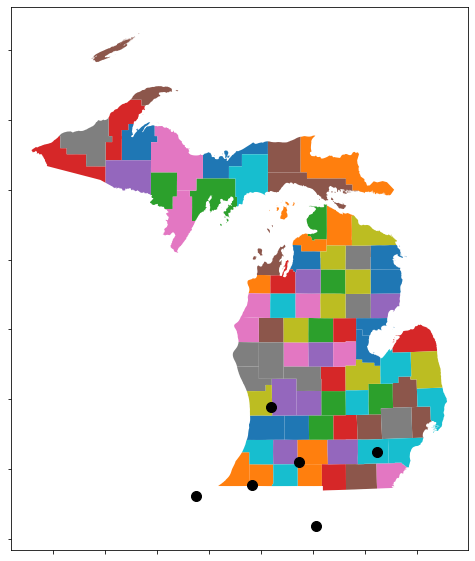

In [12]:
# Overlay points and Polygons
fig, ax = plt.subplots(figsize=(10,10))
gdf2.plot(ax=ax, column='NAME');
#ax.margins(-.2, -.2)
ax.set_xticklabels([])
ax.set_yticklabels([])
gdf.plot(ax=ax, markersize=100, color='black');

In [13]:
# dont even need this section!
import json 
response = requests.get(NHBPpa)
rText = response.text
data = json.loads(rText)
df = pd.json_normalize(data['features'])
df['geometry'] = df['geometry.coordinates']
df
df['latitude'] = df.apply(lambda row: row.geometry[1], axis=1)
df['longitude'] = df.apply(lambda row: row.geometry[0], axis=1)
df.head().T
#gdf = gpd.read_file(df)
#dfEX['SITE #'] = dfEX.apply(lambda row: siteList[row.SITE_ID], axis=1)

,0,1,2,3,4
type,Feature,Feature,Feature,Feature,Feature
properties.ID,44439,2822,5712,43297,7772
properties.label,NHBP,Milton Township,Harlan,SFront,Emu2
properties.flagged_high,0,NaN,NaN,NaN,NaN
properties.version,6.01,6.01,6.01,6.01,6.01
properties.WiFiSignal,-59,-63,-50,-61,-67
properties.PM2_5Value,2.73,3.79,4.44,2.45,0.83
properties.sensorDiff,0.98,1.16,1.31,0.38,0.33
properties.AQI,11,16,19,10,3
properties.AQIText,Good,Good,Good,Good,Good


In [14]:
for lat, lon in zip((df['latitude'])[:5], df['longitude'][:5]):
    geometry = lat, lon
    geomPts = []
    geomPts.append(geometry)
    print(geometry)

(42.102401, -85.269179)
(41.76787, -86.17218)
(41.194278, -84.930024)
(42.885923, -85.81386)
(42.252611, -83.7624)


In [15]:
# Save the geometry as a new feature
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
geometry[:5]
# Create crs dictionary
crs = 'epsg:4326'
gdf3 = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
gdf3.head()

,type,properties.ID,properties.label,properties.flagged_high,properties.version,properties.WiFiSignal,properties.PM2_5Value,properties.sensorDiff,properties.AQI,properties.AQIText,properties.AQI1Hour,properties.AQI1HourText,properties.AQI24Hour,properties.AQI24HourText,properties.AQI1Week,properties.AQI1WeekText,geometry.type,geometry.coordinates,geometry,latitude,longitude
0,Feature,44439,NHBP,0.0,6.01,-59,2.73,0.98,11,Good,NaN,Good,33,Good,41,Good,Point,"[-85.269179, 42.102401]",POINT (-85.26918 42.10240),42.102401,-85.269179
1,Feature,2822,Milton Township,NaN,6.01,-63,3.79,1.16,16,Good,NaN,Good,24,Good,28,Good,Point,"[-86.17218, 41.76787]",POINT (-86.17218 41.76787),41.767870,-86.172180
2,Feature,5712,Harlan,NaN,6.01,-50,4.44,1.31,19,Good,25.0,Good,66,Moderate,56,Moderate,Point,"[-84.930024, 41.194278]",POINT (-84.93002 41.19428),41.194278,-84.930024
3,Feature,43297,SFront,NaN,6.01,-61,2.45,0.38,10,Good,14.0,Good,46,Good,53,Moderate,Point,"[-85.81386, 42.885923]",POINT (-85.81386 42.88592),42.885923,-85.813860
4,Feature,7772,Emu2,NaN,6.01,-67,0.83,0.33,3,Good,7.0,Good,35,Good,38,Good,Point,"[-83.7624, 42.252611]",POINT (-83.76240 42.25261),42.252611,-83.762400


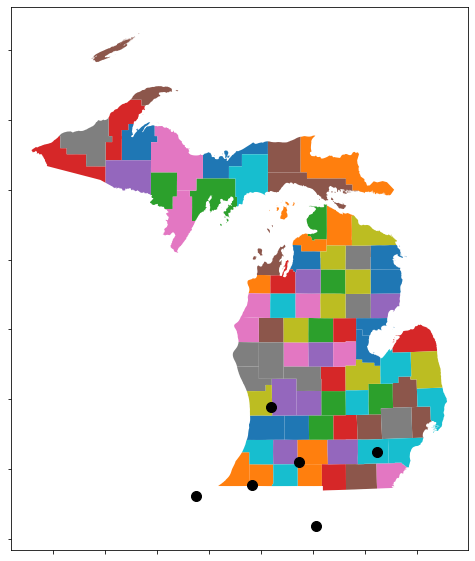

In [16]:
# Overlay points and Polygons
fig, ax = plt.subplots(figsize=(10,10))
gdf2.plot(ax=ax, column='NAME');
#ax.margins(-.2, -.2)
ax.set_xticklabels([])
ax.set_yticklabels([])
gdf3.plot(ax=ax, markersize=100, color='black');

Next step working to process entire Purple Air json as df->gdf!

In [26]:
NHBPpa = 'https://purpleairwidget.firebaseapp.com/purpleAirData/44439,2822,5712,43297,7772,37659'
PAallSta = 'https://www.purpleair.com/json'
miCounties = 'https://opendata.arcgis.com/datasets/67a8ff23b5f54f15b7133b8c30981441_0.geojson'

In [24]:
# this is bringing in the Purple Air Data as a DataFrame! 
df1 = pd.read_json(PAallSta)
#df1.head()
df3 = pd.json_normalize(df1['results'])


In [25]:
df3.head().T

,0,1,2,3,4
ID,14633,14634,25999,26000,14091
Label,Hazelwood canary,Hazelwood canary B,Villages of Bridgestone AQI,Villages of Bridgestone AQI B,WC Hillside
DEVICE_LOCATIONTYPE,outside,NaN,outside,NaN,outside
THINGSPEAK_PRIMARY_ID,559921,559923,694803,694805,553460
THINGSPEAK_PRIMARY_ID_READ_KEY,CU4BQZZ38WO5UJ4C,DULWDNCI9M6PCIPC,OO5PFS7JTQQSHQHE,OAPUW1RM0X9CJDYO,1ZIXYGGG1W61J6OI
THINGSPEAK_SECONDARY_ID,559922,559924,694804,694806,553463
THINGSPEAK_SECONDARY_ID_READ_KEY,D0YNZ1LM59LL49VQ,EY2CNMYRUZHDW1AL,LW93B1YLLZ4N4QFM,XAFZ75MBJ90SZIU7,NYFHXX29D0MHNI9F
Lat,37.2756,37.2756,30.0538,30.0538,37.8836
Lon,-121.964,-121.964,-95.4946,-95.4946,-122.07
PM2_5Value,100.35,96.45,8.53,8.49,226.63


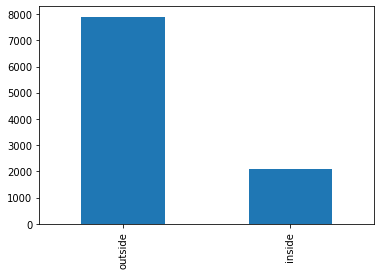

In [28]:
pd.value_counts(df3['DEVICE_LOCATIONTYPE']).plot.bar()

In [29]:
#df3.head()
df3['DEVICE_LOCATIONTYPE'].describe()
#pd.value_counts(df3['DEVICE_LOCATIONTYPE']).plot.bar()
#df3.groupby(['Hidden']).mean()
#df3['DEVICE_LOCATIONTYPE'].mean()

count        9986
unique          2
top       outside
freq         7895
Name: DEVICE_LOCATIONTYPE, dtype: object

In [32]:
for lat, lon in zip((df3['Lat'])[:5], df3['Lon'][:5]):
    geometry = lat, lon
    geomPts = []
    geomPts.append(geometry)
    print(geometry)

(37.275561, -121.964134)
(37.275561, -121.964134)
(30.053808, -95.494643)
(30.053808, -95.494643)
(37.88362, -122.070087)


In [33]:
# Save the geometry as a new feature
geometry = [Point(xy) for xy in zip(df3['Lon'], df3['Lat'])]
geometry[:5]
# Create crs dictionary
crs = 'epsg:4326'
gdf4 = gpd.GeoDataFrame(df3, crs=crs, geometry=geometry)
gdf4.head()

,ID,Label,DEVICE_LOCATIONTYPE,THINGSPEAK_PRIMARY_ID,THINGSPEAK_PRIMARY_ID_READ_KEY,THINGSPEAK_SECONDARY_ID,THINGSPEAK_SECONDARY_ID_READ_KEY,Lat,Lon,PM2_5Value,LastSeen,Type,Hidden,isOwner,humidity,temp_f,pressure,AGE,Stats,ParentID,Flag,A_H,Ozone1,geometry
0,14633,Hazelwood canary,outside,559921,CU4BQZZ38WO5UJ4C,559922,D0YNZ1LM59LL49VQ,37.275561,-121.964134,100.35,1599829851,PMS5003+PMS5003+BME280,false,0,55,69,1010.57,0,"{""v"":100.35,""v1"":105.37,""v2"":112.82,""v3"":111.3...",NaN,NaN,NaN,NaN,POINT (-121.96413 37.27556)
1,14634,Hazelwood canary B,NaN,559923,DULWDNCI9M6PCIPC,559924,EY2CNMYRUZHDW1AL,37.275561,-121.964134,96.45,1599829851,NaN,false,0,NaN,NaN,NaN,0,"{""v"":96.45,""v1"":100.78,""v2"":107.93,""v3"":106.59...",14633.0,NaN,NaN,NaN,POINT (-121.96413 37.27556)
2,25999,Villages of Bridgestone AQI,outside,694803,OO5PFS7JTQQSHQHE,694804,LW93B1YLLZ4N4QFM,30.053808,-95.494643,8.53,1599829880,PMS5003+PMS5003+BME280,false,0,69,80,1015.0,0,"{""v"":8.53,""v1"":10.32,""v2"":11.46,""v3"":12.15,""v4...",NaN,NaN,NaN,NaN,POINT (-95.49464 30.05381)
3,26000,Villages of Bridgestone AQI B,NaN,694805,OAPUW1RM0X9CJDYO,694806,XAFZ75MBJ90SZIU7,30.053808,-95.494643,8.49,1599829880,NaN,false,0,NaN,NaN,NaN,0,"{""v"":8.49,""v1"":9.63,""v2"":10.47,""v3"":10.99,""v4""...",25999.0,NaN,NaN,NaN,POINT (-95.49464 30.05381)
4,14091,WC Hillside,outside,553460,1ZIXYGGG1W61J6OI,553463,NYFHXX29D0MHNI9F,37.883620,-122.070087,226.63,1599829778,PMS5003+PMS5003+BME280,false,0,56,66,1005.08,1,"{""v"":226.63,""v1"":222.22,""v2"":220.89,""v3"":219.5...",NaN,1.0,NaN,NaN,POINT (-122.07009 37.88362)


In [34]:
#working to drop null lat/lon records, preventing gdf from being plotted
#Yes it worked!  Ran after geomtry was constructed, but could be done before
gdf4.isnull().sum()

ID                                      0
Label                                   0
DEVICE_LOCATIONTYPE                 10191
THINGSPEAK_PRIMARY_ID                   0
THINGSPEAK_PRIMARY_ID_READ_KEY          0
THINGSPEAK_SECONDARY_ID                 0
THINGSPEAK_SECONDARY_ID_READ_KEY        0
Lat                                   173
Lon                                   173
PM2_5Value                           1492
LastSeen                                0
Type                                10060
Hidden                                  0
isOwner                                 0
humidity                            10315
temp_f                              10315
pressure                            10315
AGE                                     0
Stats                                1492
ParentID                            10089
Flag                                19138
A_H                                 19993
Ozone1                              20170
geometry                          

In [35]:
gdf5 = gdf4.dropna(subset=['Lat','Lon'])
gdf5.isnull().sum()

ID                                      0
Label                                   0
DEVICE_LOCATIONTYPE                 10088
THINGSPEAK_PRIMARY_ID                   0
THINGSPEAK_PRIMARY_ID_READ_KEY          0
THINGSPEAK_SECONDARY_ID                 0
THINGSPEAK_SECONDARY_ID_READ_KEY        0
Lat                                     0
Lon                                     0
PM2_5Value                           1476
LastSeen                                0
Type                                 9957
Hidden                                  0
isOwner                                 0
humidity                            10209
temp_f                              10209
pressure                            10209
AGE                                     0
Stats                                1476
ParentID                            10019
Flag                                18972
A_H                                 19820
Ozone1                              19997
geometry                          

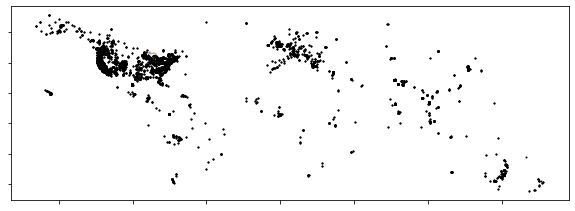

In [36]:
# Overlay points and Polygons
fig, ax = plt.subplots(figsize=(10,10))
gdf2.plot(ax=ax, column='NAME');
#ax.margins(-.2, -.2)
ax.set_xticklabels([])
ax.set_yticklabels([])
gdf5.plot(ax=ax, markersize=1, color='black');

In [38]:
m = folium.Map()
folium.GeoJson(gdf3).add_to(m)
m

In [ ]:
from folium.plugins import FastMarkerCluster
aqSample = gdf5
lons = aqSample['Lon'] 
lats = aqSample['Lat']
m = folium.Map(
    location = [np.mean(aqSample.Lat), np.mean(aqSample.Lon)],
    tiles= 'Stamen Toner',
    zoom_start=5
    )
FastMarkerCluster(data=list(zip(lats, lons))).add_to(m)
folium.LayerControl().add_to(m)
m